In [27]:
import pandas as pd

df1 = pd.read_csv('positive.csv', na_values=['NULL'])

df2 = pd.read_csv('negative.csv', na_values=['NULL'])

df = pd.concat([df1, df2], ignore_index=True)

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [29]:
from sklearn.model_selection import train_test_split
import pandas as pd

y = df["MI_Phys"]
X = df.drop(columns=["PatientID", "12SL_Codes", "Phys_Codes", "TestID", "Source", 
                     "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save the original algorithm's prediction for test set before dropping it
y_12SL = X_test["MI_12SL"]

# Split data based on MI_12SL classification
X_train_pos = X_train[X_train["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_train_neg = X_train[X_train["MI_12SL"] == 0].drop(columns=["MI_12SL"])
X_test_pos = X_test[X_test["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_test_neg = X_test[X_test["MI_12SL"] == 0].drop(columns=["MI_12SL"])

# Ensure y labels match the correct samples
y_train_pos = y_train.loc[X_train_pos.index]  # True positives or false positives
y_train_neg = y_train.loc[X_train_neg.index]  # True negatives or false negatives
y_test_pos = y_test.loc[X_test_pos.index]
y_test_neg = y_test.loc[X_test_neg.index]

X_train = X_train.drop(columns=["MI_12SL"])
X_test = X_test.drop(columns=["MI_12SL"])

# Extract MI_12SL predictions
y_12SL_pos = y_12SL.loc[X_test_pos.index]  # Original classifier's labels
y_12SL_neg = y_12SL.loc[X_test_neg.index]


In [30]:
#count number of positive and negative values based on MI_Phys
print(df1['MI_Phys'].value_counts())

MI_Phys
0    5419
1    4003
Name: count, dtype: int64


In [31]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'dart',
    'colsample_bytree': 0.862199,
    'n_estimators': 1000,
    'learning_rate': 0.170722,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 69,
    'min_child_weight': 3,
    'max_depth' : 9,
    'reg_alpha' : 0.2958433,
    'reg_lambda' : 0.54682407,
    'subsample' : 0.85968,
    # 'metric': 'auc', 
    'scale_pos_weight': 20,
    }
model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.8079957916885849


In [32]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = X_train_pos
y = y_train_pos

# Hyperparameter search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'rf']),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        objective='binary',
        # metric='auc',
        verbose=-1,
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, scoring='f1', cv=cv).mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  
    trials=trials,
    rstate=np.random.Generator(np.random.PCG64(42))
)

print("Best hyperparameters:", best)


100%|██████████| 100/100 [21:37<00:00, 12.98s/trial, best loss: 0.19555853864190487]
Best hyperparameters: {'boosting_type': 0, 'colsample_bytree': 0.9889166151269666, 'learning_rate': 0.08075858318520863, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_leaves': 106.0, 'reg_alpha': 0.7909697583404915, 'reg_lambda': 0.6134818268917115, 'scale_pos_weight': 3.537715990816648, 'subsample': 0.9300541891859395}


In [33]:
#run model with the parameters from the dictionary with the model parameters from "best"
boosting_type = ['gbdt', 'dart', 'rf']
best['boosting_type'] = boosting_type[best['boosting_type']]
lgb_params = {
    'objective': 'binary',
    'boosting_type': best['boosting_type'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': best['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'max_depth' : int(best['max_depth']),
    'reg_alpha' : best['reg_alpha'],
    'reg_lambda' : best['reg_lambda'],
    'subsample' : best['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': best['scale_pos_weight'],
    }

model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.8221988427143608


In [34]:
# optuna optimization
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

X = X_train_pos
y = y_train_pos

def objective(trial):
    # Define the search space using trial.suggest_
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

    clf = lgb.LGBMClassifier(
        n_estimators=500,
        objective='binary',
        boosting_type=boosting_type,
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        verbose=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    mean_f1 = np.mean(f1_scores)

    return 1 - mean_f1  # Optuna minimizes the objective

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1) 

print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", 1 - study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-04-03 20:47:55,829] A new study created in memory with name: no-name-b61367db-80eb-4ca0-b9ce-40881159f5d4
[I 2025-04-03 20:48:57,621] Trial 9 finished with value: 0.28173169807466947 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'max_depth': 3, 'learning_rate': 0.012259173455412303, 'subsample': 0.6766988422752152, 'colsample_bytree': 0.7735669581483042, 'reg_alpha': 0.0838688630556339, 'reg_lambda': 0.7836844430045323, 'min_child_weight': 4, 'scale_pos_weight': 4.261166645192858}. Best is trial 9 with value: 0.28173169807466947.
[I 2025-04-03 20:49:00,798] Trial 3 finished with value: 0.21165975007859217 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.16731960057229028, 'subsample': 0.8993010280384952, 'colsample_bytree': 0.9340044376122316, 'reg_alpha': 0.18486797057809146, 'reg_lambda': 0.48342680979873565, 'min_child_weight': 5, 'scale_pos_weight': 6.475807705425136}. Best is trial 3 with value: 0.211659750078592

Best trial:
FrozenTrial(number=12, state=1, values=[0.1940776269464315], datetime_start=datetime.datetime(2025, 4, 3, 20, 47, 55, 852093), datetime_complete=datetime.datetime(2025, 4, 3, 20, 54, 55, 937063), params={'boosting_type': 'dart', 'num_leaves': 110, 'max_depth': 10, 'learning_rate': 0.1949433594115455, 'subsample': 0.7708427898555973, 'colsample_bytree': 0.817862650122246, 'reg_alpha': 0.0515821629764589, 'reg_lambda': 0.380360667705575, 'min_child_weight': 2, 'scale_pos_weight': 9.423967998899137}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart', 'rf')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.005, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=Fals

In [37]:
#run model with optuna best params

lgb_params = {
    'objective': 'binary',
    'boosting_type': study.best_params['boosting_type'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': study.best_params['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(study.best_params['num_leaves']),
    'min_child_weight': int(study.best_params['min_child_weight']),
    'max_depth' : int(study.best_params['max_depth']),
    'reg_alpha' : study.best_params['reg_alpha'],
    'reg_lambda' : study.best_params['reg_lambda'],
    'subsample' : study.best_params['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': study.best_params['scale_pos_weight'],
}

model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.8148342977380326


In [38]:
# Predict probabilities or classes from your second model trained on 12SL positives
y_pos_pred_proba = model_pos.predict_proba(X_test_pos)[:, 1]
threshold = 0.5
y_pos_pred = (y_pos_pred_proba >= threshold).astype(int)

# Keep alignment with X_test_pos
results_pos = pd.DataFrame({
    'true': y_test_pos,
    'pred': y_pos_pred,
    'prob': y_pos_pred_proba
}, index=X_test_pos.index)


false_positives_pos = results_pos[(results_pos['pred'] == 1) & (results_pos['true'] == 0)]
false_negatives_pos = results_pos[(results_pos['pred'] == 0) & (results_pos['true'] == 1)]

X_fp_pos = X_test_pos.loc[false_positives_pos.index]
X_fn_pos = X_test_pos.loc[false_negatives_pos.index]


 94%|=================== | 202/216 [00:13<00:00]         

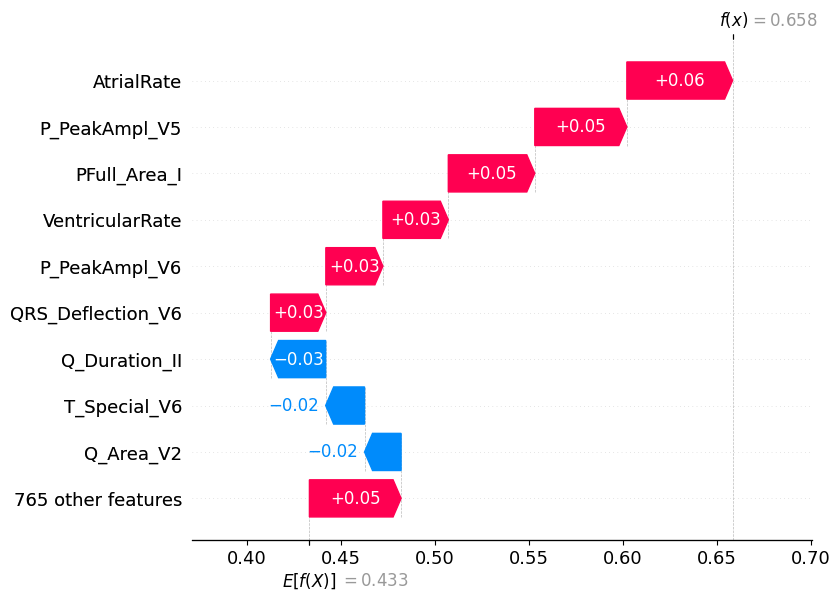

In [39]:
import shap

background = X_train_pos.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_pos)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_pos)
shap_values_fn = explainer.shap_values(X_fn_pos)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fp[0], feature_names=X_fp_pos.columns)


 94%|=================== | 203/216 [00:13<00:00]         

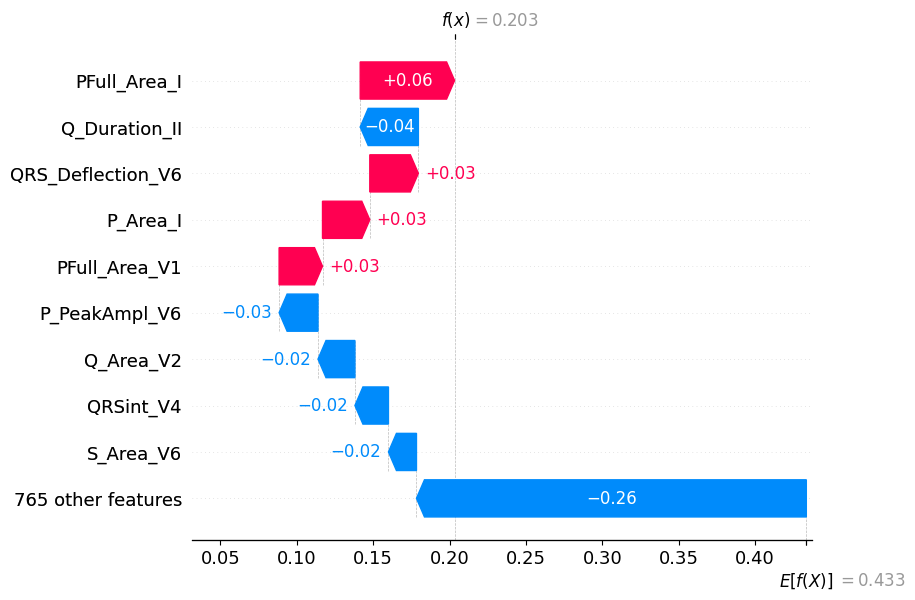

In [40]:
import shap

background = X_train_pos.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_pos)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_pos)
shap_values_fn = explainer.shap_values(X_fn_pos)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fn[0], feature_names=X_fn_pos.columns)


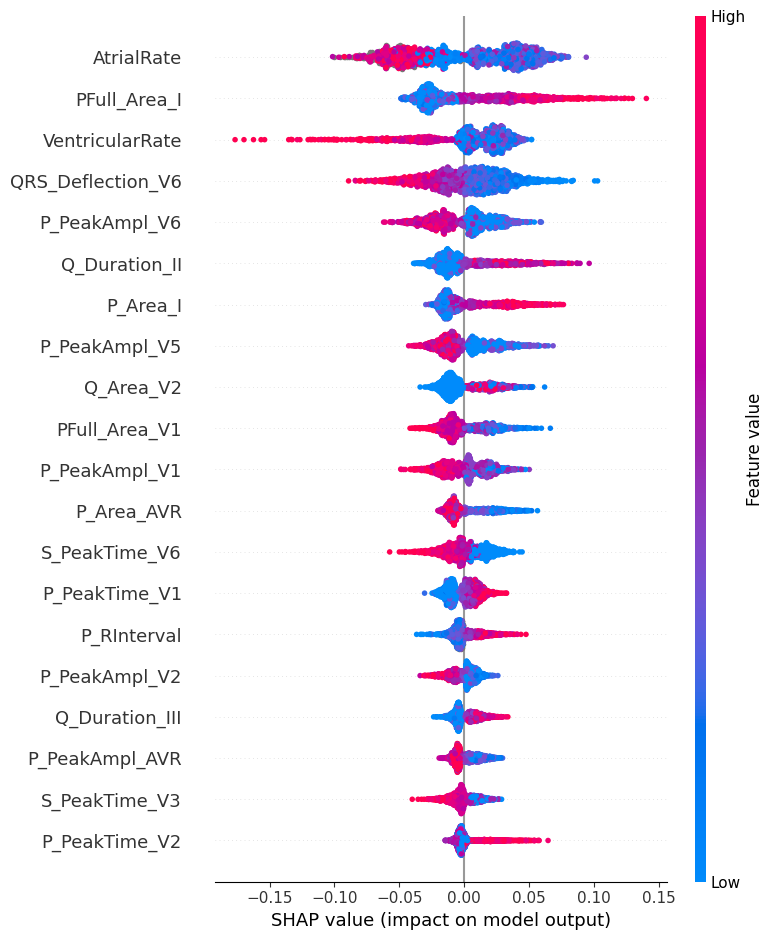

In [41]:
shap.summary_plot(shap_values, X_test_pos)

In [42]:
import matplotlib.pyplot as plt

feature = 'Some_Feature_Name'
plt.hist(X_test_pos[feature], bins=50, alpha=0.5, label='All 12SL Positives')
plt.axvline(X_fp_pos[feature].mean(), color='red', label='FP Mean')
plt.axvline(X_fn_pos[feature].mean(), color='green', label='FN Mean')
plt.legend()
plt.title(f'Distribution of {feature}')
plt.show()

KeyError: 'Some_Feature_Name'

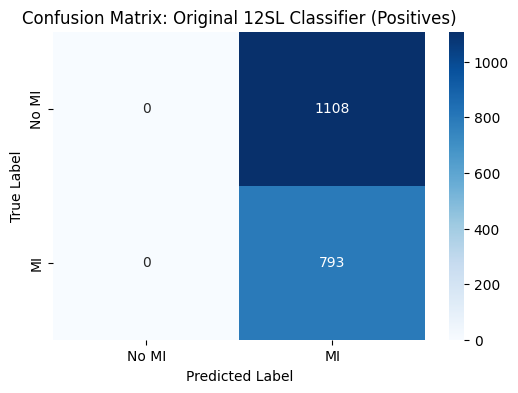

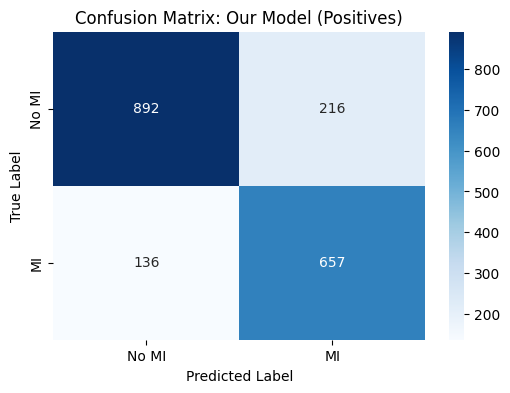

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#confusion matrix 12SL (no model)

cm = confusion_matrix(y_test_pos, y_12SL_pos)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Original 12SL Classifier (Positives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#confusion matrix (from model)

cm = confusion_matrix(y_test_pos, y_pred_pos)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Our Model (Positives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Baseline Sensitivity (Recall): 1.0
Baseline Precision (PPV): 0.4171488690163072
Model Sensitivity (Recall): 0.8284993694829761
Model Precision (PPV): 0.7525773195876289


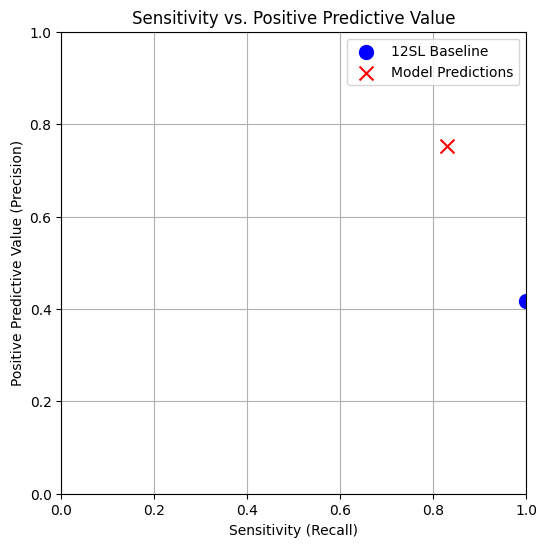

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

y_true = y_test_pos  # Ground truth for positive subset
baseline_pred = y_12SL.loc[y_test_pos.index]  # 12SL classifier predictions for the same subset
model_pred = y_pred_pos  # Predictions from your trained model

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

sensitivity_model = recall_score(y_true, model_pred)
precision_model = precision_score(y_true, model_pred)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Model Sensitivity (Recall):", sensitivity_model)
print("Model Precision (PPV):", precision_model)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='12SL Baseline', color='blue', marker='o', s=100)
plt.scatter(sensitivity_model, precision_model, 
            label='Model Predictions', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. Positive Predictive Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


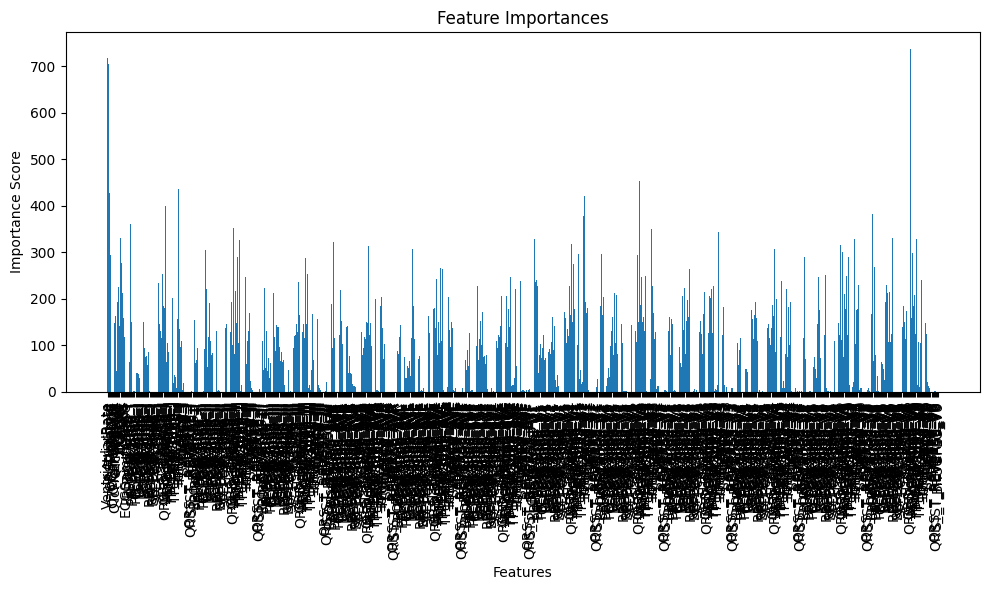

In [53]:
import matplotlib.pyplot as plt
import numpy as np

importances = model_pos.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


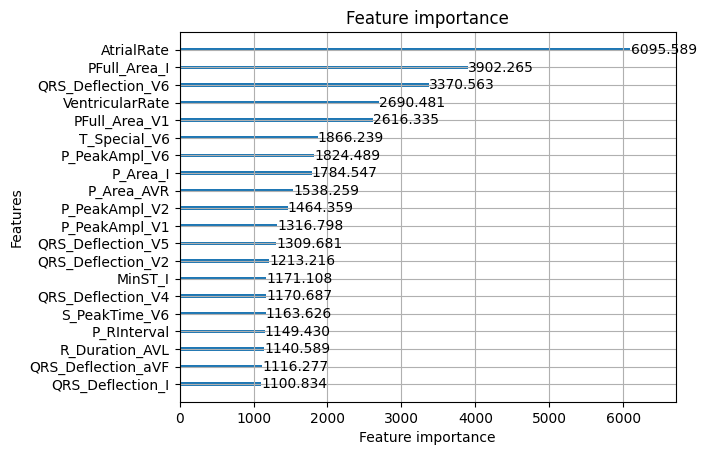

In [54]:
booster = model_pos.booster_
importances = booster.feature_importance(importance_type='split')
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Number of components selected: 277
Total variance explained: 0.9501401527639173
Principal components shape: (61047, 277)


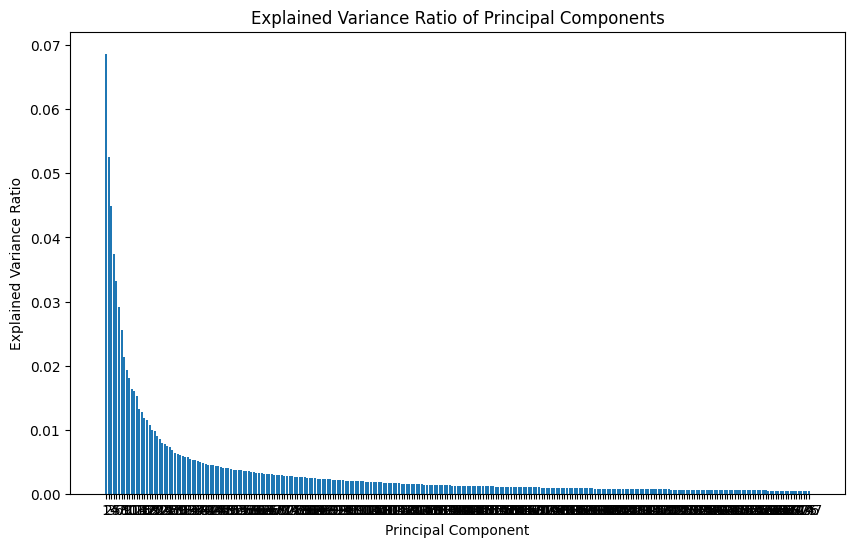

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cols = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys'])
# drop NaN values
df_cols = df_cols.dropna()
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())
print("Principal components shape:", principal_components.shape)
#column names from original data
feature_names = df_cols.columns

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

In [56]:
# Negative Model

In [57]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 10,
    }
model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.9564255695642557


In [58]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = X_train_neg
y = y_train_neg

# Hyperparameter search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        objective='binary',
        # metric='auc',
        verbose=-1,
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, scoring='f1', cv=cv).mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  
    trials=trials,
    rstate=np.random.Generator(np.random.PCG64(42))
)

print("Best hyperparameters:", best)


100%|██████████| 100/100 [1:04:08<00:00, 38.49s/trial, best loss: 0.4468083185371544]
Best hyperparameters: {'boosting_type': 1, 'colsample_bytree': 0.9041316021182457, 'learning_rate': 0.11161981161173745, 'max_depth': 10.0, 'min_child_weight': 7.0, 'num_leaves': 35.0, 'reg_alpha': 0.36488851147252865, 'reg_lambda': 0.6044768790531618, 'scale_pos_weight': 7.987306868405997, 'subsample': 0.6702585072378204}


In [59]:
#run model with the parameters from the dictionary with the model parameters from "best"
boosting_type = ['gbdt', 'dart']
best['boosting_type'] = boosting_type[best['boosting_type']]
lgb_params = {
    'objective': 'binary',
    'boosting_type': best['boosting_type'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': best['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'max_depth' : int(best['max_depth']),
    'reg_alpha' : best['reg_alpha'],
    'reg_lambda' : best['reg_lambda'],
    'subsample' : best['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': best['scale_pos_weight'],
    }

model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.9510432795104328


In [60]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

X = X_train_neg
y = y_train_neg

def objective(trial):
    # Define the search space
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

    # Construct classifier
    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        objective='binary',
        boosting_type=boosting_type,
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        verbose=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    mean_f1 = np.mean(f1_scores)

    return 1 - mean_f1  # Optuna minimizes the objective

# Create and run the Optuna study
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best trial:")
print(study.best_trial)
print("Best F1 Score:", 1 - study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-04-03 23:29:59,184] A new study created in memory with name: no-name-b9c25452-0f78-4f21-8f2d-f5a306d6416f
[I 2025-04-03 23:35:14,358] Trial 21 finished with value: 0.49636751669038304 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'max_depth': 3, 'learning_rate': 0.013288808758047239, 'subsample': 0.9157875291399062, 'colsample_bytree': 0.7551199356379124, 'reg_alpha': 0.4245981302826547, 'reg_lambda': 0.13870773966919814, 'min_child_weight': 10, 'scale_pos_weight': 5.287229018554403}. Best is trial 21 with value: 0.49636751669038304.
[I 2025-04-03 23:35:38,458] Trial 6 finished with value: 0.46772279142293405 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.14556179273007983, 'subsample': 0.7525350375373275, 'colsample_bytree': 0.7072857134104232, 'reg_alpha': 0.08283097295383113, 'reg_lambda': 0.7640405582487737, 'min_child_weight': 3, 'scale_pos_weight': 9.071220008568712}. Best is trial 6 with value: 0.467722791422

Best trial:
FrozenTrial(number=71, state=1, values=[0.4466846123078134], datetime_start=datetime.datetime(2025, 4, 4, 0, 48, 58, 131935), datetime_complete=datetime.datetime(2025, 4, 4, 1, 37, 56, 253990), params={'boosting_type': 'dart', 'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.07126342067319905, 'subsample': 0.8082227185091655, 'colsample_bytree': 0.9530934137568272, 'reg_alpha': 0.9777141782749744, 'reg_lambda': 0.45491386942993794, 'min_child_weight': 8, 'scale_pos_weight': 9.084081085433482}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.005, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, lo

In [61]:
#run model with optuna best params
lgb_params = {
    'objective': 'binary',
    'boosting_type': study.best_params['boosting_type'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': study.best_params['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(study.best_params['num_leaves']),
    'min_child_weight': int(study.best_params['min_child_weight']),
    'max_depth' : int(study.best_params['max_depth']),
    'reg_alpha' : study.best_params['reg_alpha'],
    'reg_lambda' : study.best_params['reg_lambda'],
    'subsample' : study.best_params['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': study.best_params['scale_pos_weight'],
}

model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.9525916095259161


In [62]:

# Predict probabilities or classes from your second model trained on 12SL positives
y_pos_pred_proba = model_neg.predict_proba(X_test_neg)[:, 1]
threshold = 0.5
y_pos_pred = (y_pos_pred_proba >= threshold).astype(int)

# Keep alignment with X_test_pos
results_neg = pd.DataFrame({
    'true': y_test_neg,
    'pred': y_pos_pred,
    'prob': y_pos_pred_proba
}, index=X_test_neg.index)


false_positives_neg = results_neg[(results_neg['pred'] == 1) & (results_neg['true'] == 0)]
false_negatives_neg = results_neg[(results_neg['pred'] == 0) & (results_neg['true'] == 1)]

X_fp_neg = X_test_neg.loc[false_positives_neg.index]
X_fn_neg = X_test_neg.loc[false_negatives_neg.index]


 99%|===================| 314/316 [00:17<00:00]            

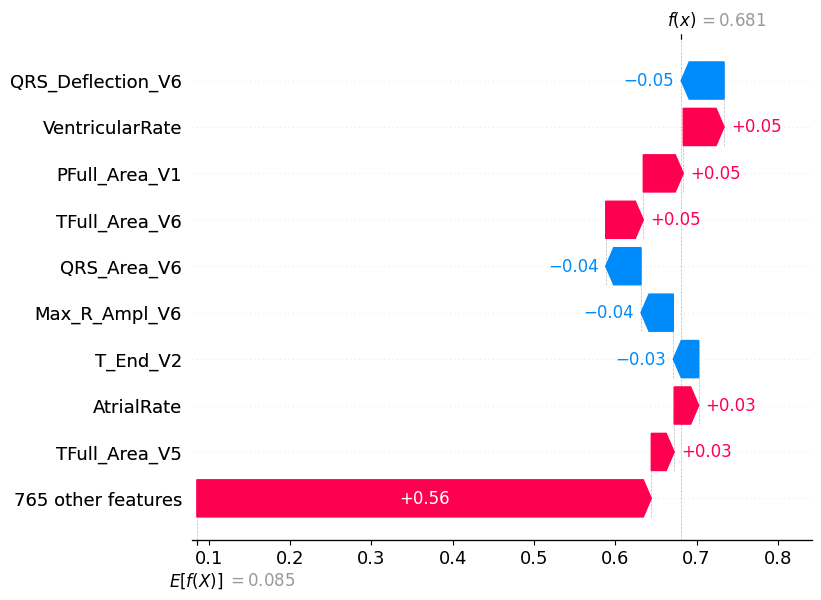

In [63]:
import shap

background = X_train_neg.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_neg,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_neg)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_neg)
shap_values_fn = explainer.shap_values(X_fn_neg)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fp[0], feature_names=X_fp_neg.columns)


 97%|=================== | 305/316 [00:18<00:00]           

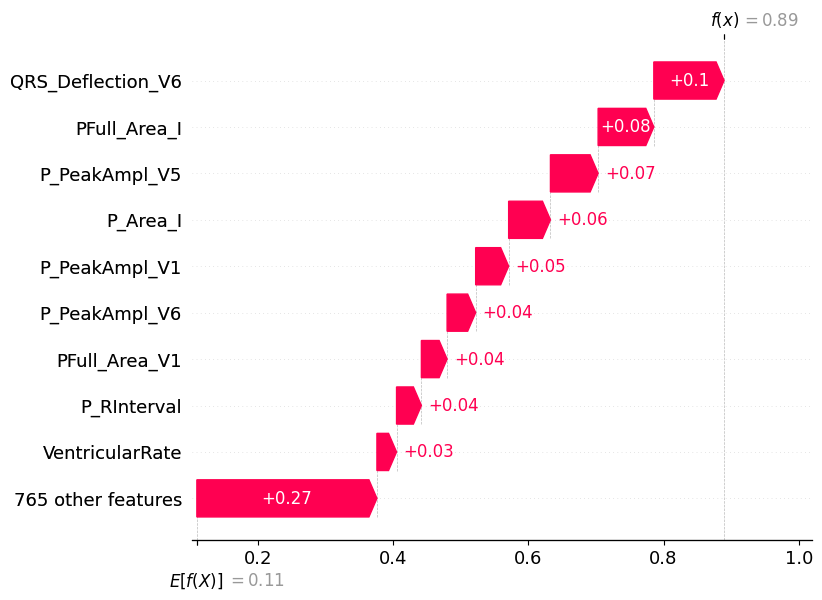

In [64]:
import shap

background = X_train_neg.sample(100, random_state=42)

# Create the explainer with reference data
explainer = shap.TreeExplainer(
    model_pos,
    data=background,
    model_output='probability',
    feature_perturbation='interventional'
)

# Now generate SHAP values without error
shap_values = explainer.shap_values(X_test_neg)

# SHAP values for FPs and FNs in the positive model
shap_values_fp = explainer.shap_values(X_fp_neg)
shap_values_fn = explainer.shap_values(X_fn_neg)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_fn[0], feature_names=X_fn_neg.columns)


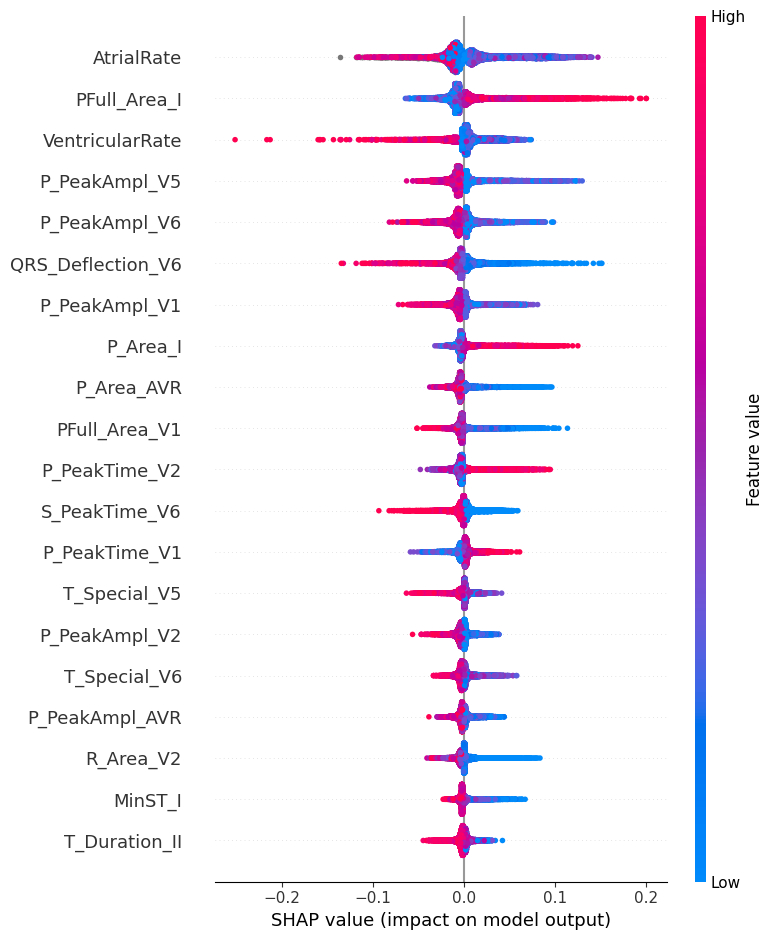

In [65]:
shap.summary_plot(shap_values, X_test_neg)

In [66]:
# import matplotlib.pyplot as plt

# feature = 'Some_Feature_Name'
# plt.hist(X_test_neg[feature], bins=50, alpha=0.5, label='All 12SL Positives')
# plt.axvline(X_fp_neg[feature].mean(), color='red', label='FP Mean')
# plt.axvline(X_fn_neg[feature].mean(), color='green', label='FN Mean')
# plt.legend()
# plt.title(f'Distribution of {feature}')
# plt.show()

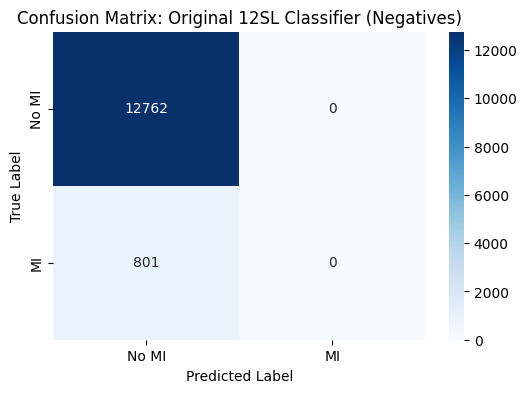

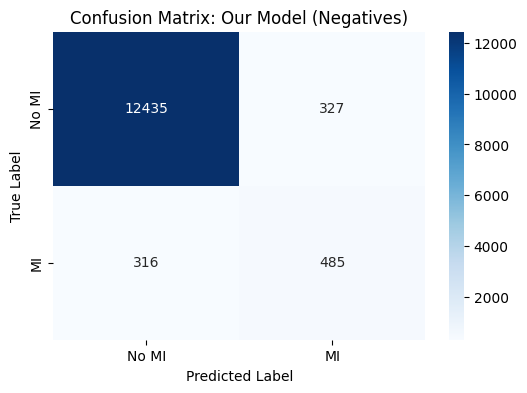

In [67]:
#confusion matrix 12SL (no model)

cm = confusion_matrix(y_test_neg, y_12SL_neg)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Original 12SL Classifier (Negatives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#confusion matrix (from model)

cm = confusion_matrix(y_test_neg, y_pred_neg)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Our Model (Negatives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Baseline Sensitivity (Recall): 0.0
Baseline Precision (PPV): 0.0
Model Sensitivity (Recall): 0.6054931335830213
Model Precision (PPV): 0.5972906403940886


c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


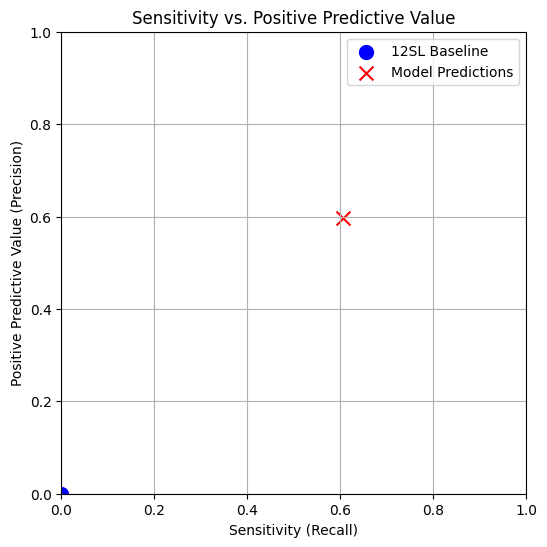

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

y_true = y_test_neg  # Ground truth for positive subset
baseline_pred = y_12SL.loc[y_test_neg.index]  # 12SL classifier predictions for the same subset
model_pred = y_pred_neg  # Predictions from your trained model

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

sensitivity_model = recall_score(y_true, model_pred)
precision_model = precision_score(y_true, model_pred)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Model Sensitivity (Recall):", sensitivity_model)
print("Model Precision (PPV):", precision_model)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='12SL Baseline', color='blue', marker='o', s=100)
plt.scatter(sensitivity_model, precision_model, 
            label='Model Predictions', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. Positive Predictive Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


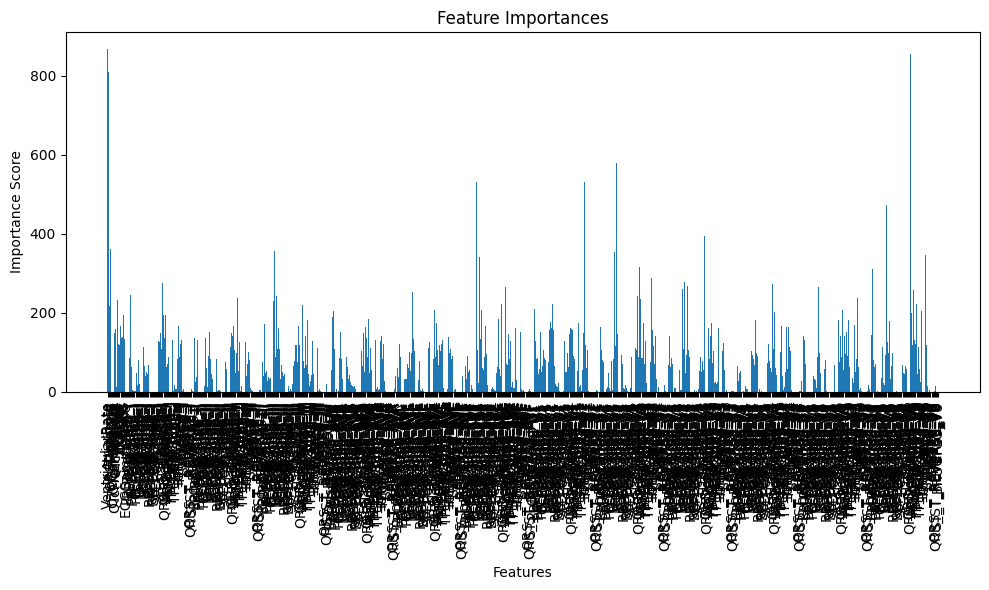

In [69]:
importances = model_neg.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


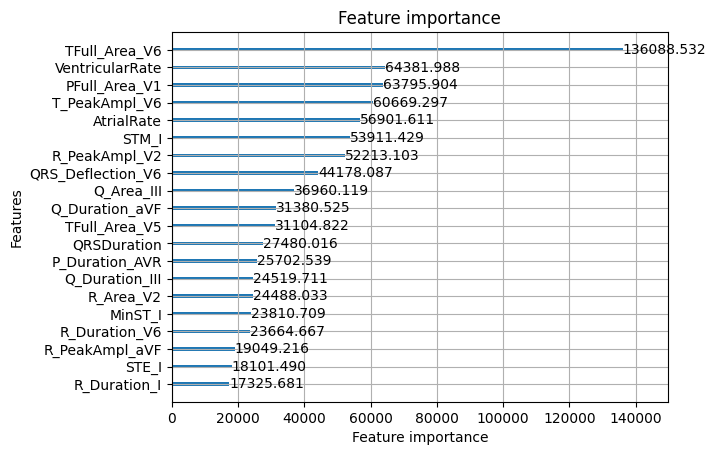

In [70]:
booster = model_neg.booster_
importances = booster.feature_importance(importance_type='split')
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Baseline Sensitivity (Recall): 0.4974905897114178
Baseline Precision (PPV): 0.4171488690163072
Combined Model Sensitivity (Recall): 0.7164366373902133
Combined Model Precision (PPV): 0.6777448071216617


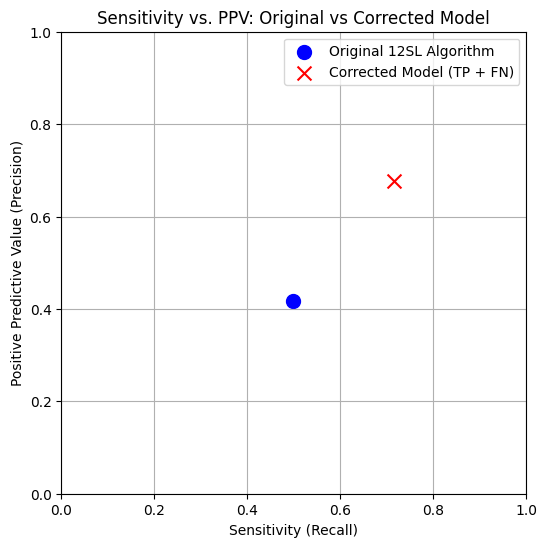

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

#Compute performance for the original algorithm (MI_12SL)
y_true = y_test
baseline_pred = y_12SL 

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

#Generate Combined Model Predictions
y_pred_pos = model_pos.predict(X_test_pos)
y_pred_neg = model_neg.predict(X_test_neg)

# Merge the corrected predictions into a single output
y_pred_combined = y_12SL.copy()  # original MI_12SL predictions
y_pred_combined.loc[X_test_pos.index] = y_pred_pos  # Replace with TP model results
y_pred_combined.loc[X_test_neg.index] = y_pred_neg  # Replace with FN model results

#Compute performance for the Combined Model
sensitivity_combined = recall_score(y_true, y_pred_combined)
precision_combined = precision_score(y_true, y_pred_combined)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Combined Model Sensitivity (Recall):", sensitivity_combined)
print("Combined Model Precision (PPV):", precision_combined)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='Original 12SL Algorithm', color='blue', marker='o', s=100)
plt.scatter(sensitivity_combined, precision_combined, 
            label='Corrected Model (TP + FN)', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. PPV: Original vs Corrected Model')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
